# Porto Seguro’s Safe Driver Prediction
- Predict if a driver will file an insurance claim next year.
- https://www.kaggle.com/c/porto-seguro-safe-driver-prediction/data
- install: http://jupyter-contrib-nbextensions.readthedocs.io/en/latest/install.html
- install: https://github.com/Jupyter-contrib/jupyter_nbextensions_configurator


# Credit to:
* https://www.kaggle.com/arthurtok/interactive-porto-insights-a-plot-ly-tutorial
* https://www.kaggle.com/anokas/simple-xgboost-btb-0-27
* https://www.kaggle.com/rshally/porto-xgb-lgb-kfold-lb-0-282
* https://www.kaggle.com/akashdeepjassal/simple-keras-mlp/code
* https://www.kaggle.com/pnagel/keras-starter/code
* https://datascience.stackexchange.com/questions/13490/how-to-set-class-weights-for-imbalanced-classes-in-keras

# Library import

In [1]:
# data processing
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# ML
# # Scikit-learn
from sklearn.model_selection import cross_val_score, train_test_split, learning_curve, validation_curve, KFold
from sklearn.utils import class_weight
from sklearn.preprocessing import LabelBinarizer, StandardScaler

# LightGBM
from lightgbm import LGBMClassifier, LGBMRegressor

# Keras
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.wrappers.scikit_learn import KerasRegressor
from keras.optimizers import SGD, Adam
from keras.utils import np_utils
from keras.utils.vis_utils import model_to_dot
from keras.utils import plot_model
# System
import pydot
from IPython.display import SVG
import datetime as dtime
import time

Using TensorFlow backend.


# Load data

In [2]:
pd.options.display.float_format = '{:,.4f}'.format
# Input data files are available in the DATA_DIR directory.
DATA_DIR = "data-temp"
# Load data. Download from:https://www.kaggle.com/c/nyc-taxi-trip-duration/data
train_data = pd.read_csv(DATA_DIR + "/train.csv")
eval_data =  pd.read_csv(DATA_DIR + "/test.csv")

In [3]:
print("train size:", train_data.shape, " test size:", eval_data.shape)

train size: (595212, 59)  test size: (892816, 58)


In [4]:
train_data.head(5)

,id,target,ps_ind_01,ps_ind_02_cat,ps_ind_03,ps_ind_04_cat,ps_ind_05_cat,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,...,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin
0,7,0,2,2,5,1,0,0,1,0,...,9,1,5,8,0,1,1,0,0,1
1,9,0,1,1,7,0,0,0,0,1,...,3,1,1,9,0,1,1,0,1,0
2,13,0,5,4,9,1,0,0,0,1,...,4,2,7,7,0,1,1,0,1,0
3,16,0,0,1,2,0,0,1,0,0,...,2,2,4,9,0,0,0,0,0,0
4,17,0,0,2,0,1,0,1,0,0,...,3,1,1,3,0,0,0,1,1,0


In [5]:
eval_data.head(5)

,id,ps_ind_01,ps_ind_02_cat,ps_ind_03,ps_ind_04_cat,ps_ind_05_cat,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,ps_ind_09_bin,...,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin
0,0,0,1,8,1,0,0,1,0,0,...,1,1,1,12,0,1,1,0,0,1
1,1,4,2,5,1,0,0,0,0,1,...,2,0,3,10,0,0,1,1,0,1
2,2,5,1,3,0,0,0,0,0,1,...,4,0,2,4,0,0,0,0,0,0
3,3,0,1,6,0,0,1,0,0,0,...,5,1,0,5,1,0,1,0,0,0
4,4,5,1,7,0,0,0,0,0,1,...,4,0,0,4,0,1,1,0,0,1


In [6]:
diff_cols = np.setdiff1d(train_data.columns.values, eval_data.columns.values)
diff_cols

array(['target'], dtype=object)

## Combine train data and eval data

In [7]:
label = 'target'
features = eval_data.columns.values
target = train_data[label]
combine_data = pd.concat([train_data[features], eval_data], keys=['train','eval'])
print("combine data:", len(combine_data))
combine_data.head(5)

combine data: 1488028


id  ps_ind_01  ps_ind_02_cat  ps_ind_03  ps_ind_04_cat  \
train 0   7          2              2          5              1   
      1   9          1              1          7              0   
      2  13          5              4          9              1   
      3  16          0              1          2              0   
      4  17          0              2          0              1   

         ps_ind_05_cat  ps_ind_06_bin  ps_ind_07_bin  ps_ind_08_bin  \
train 0              0              0              1              0   
      1              0              0              0              1   
      2              0              0              0              1   
      3              0              1              0              0   
      4              0              1              0              0   

         ps_ind_09_bin       ...        ps_calc_11  ps_calc_12  ps_calc_13  \
train 0              0       ...                 9           1           5   
      1              0       ...                 3           1           1   
      2              0       ...                 4           2           7   
      3              0       ...                 2           2           4   
      4              0       ...                 3           1           1   

         ps_calc_14  ps_calc_15_bin  ps_calc_16_bin  ps_calc_17_bin  \
train 0           8               0               1               1   
      1           9               0               1               1   
      2           7               0               1               1   
      3           9               0               0               0   
      4           3               0               0               0   

         ps_calc_18_bin  ps_calc_19_bin  ps_calc_20_bin  
train 0               0               0               1  
      1               0               1               0  
      2               0               1               0  
      3               0               0               0  
      4               1               1               0  

[5 rows x 58 columns]

# Pre-process data

## Check& Fill  NaN 

In [8]:
def check_null_data(data):
    #Get high percent of NaN data
    null_data = data.isnull()
    total = null_data.sum().sort_values(ascending=False)
    percent = (null_data.sum()/null_data.count()).sort_values(ascending=False)
    missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
    high_percent_miss_data = missing_data[missing_data['Percent']>0]
    #print(missing_data)
    print(high_percent_miss_data)
    miss_data_cols = high_percent_miss_data.index.values
    return miss_data_cols

In [9]:
# combine data for null
check_null_data(combine_data)

Empty DataFrame
Columns: [Total, Percent]
Index: []


array([], dtype=object)

## Split train_set and eval_set

In [10]:
data = combine_data
train_set = data.loc['train']
eval_set = data.loc['eval']
data = train_set
data.loc[:,label] = target
data[:5]

/usr/local/lib/python3.5/dist-packages/pandas/core/indexing.py:337: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/usr/local/lib/python3.5/dist-packages/pandas/core/indexing.py:517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


,id,ps_ind_01,ps_ind_02_cat,ps_ind_03,ps_ind_04_cat,ps_ind_05_cat,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,ps_ind_09_bin,...,ps_calc_12,ps_calc_13,ps_calc_14,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin,target
0,7,2,2,5,1,0,0,1,0,0,...,1,5,8,0,1,1,0,0,1,0
1,9,1,1,7,0,0,0,0,1,0,...,1,1,9,0,1,1,0,1,0,0
2,13,5,4,9,1,0,0,0,1,0,...,2,7,7,0,1,1,0,1,0,0
3,16,0,1,2,0,0,1,0,0,0,...,2,4,9,0,0,0,0,0,0,0
4,17,0,2,0,1,0,1,0,0,0,...,1,1,3,0,0,0,1,1,0,0


# Train model

In [11]:
real_vars = ['ps_ind_01', 'ps_ind_03', 'ps_ind_14', 'ps_ind_15', 'ps_reg_01', 'ps_reg_02', 'ps_reg_03', 'ps_car_11', 'ps_car_12', 'ps_car_13', 'ps_car_14', 'ps_car_15', 'ps_calc_01', 'ps_calc_02', 'ps_calc_03', 'ps_calc_04', 'ps_calc_05', 'ps_calc_06', 'ps_calc_07', 'ps_calc_08', 'ps_calc_09', 'ps_calc_10', 'ps_calc_11', 'ps_calc_12', 'ps_calc_13', 'ps_calc_14']
data = train_set.drop(['id', label], axis=1)
#data = train_set[real_vars]
print(data.shape)
data[:5]

(595212, 57)


,ps_ind_01,ps_ind_02_cat,ps_ind_03,ps_ind_04_cat,ps_ind_05_cat,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,ps_ind_09_bin,ps_ind_10_bin,...,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin
0,2,2,5,1,0,0,1,0,0,0,...,9,1,5,8,0,1,1,0,0,1
1,1,1,7,0,0,0,0,1,0,0,...,3,1,1,9,0,1,1,0,1,0
2,5,4,9,1,0,0,0,1,0,0,...,4,2,7,7,0,1,1,0,1,0
3,0,1,2,0,0,1,0,0,0,0,...,2,2,4,9,0,0,0,0,0,0
4,0,2,0,1,0,1,0,0,0,0,...,3,1,1,3,0,0,0,1,1,0


## Compute class weigth for unbalanced labels
* credit to: https://datascience.stackexchange.com/questions/13490/how-to-set-class-weights-for-imbalanced-classes-in-keras

In [12]:
cw = class_weight.compute_class_weight('balanced', np.unique(target), target)
class_weight_dict = dict(enumerate(cw))
class_weight_dict

{0: 0.51891309427079879, 1: 13.718355305614455}

## Prepare train data

### Split train/test set

In [13]:
X_train, X_test, Y_train, Y_test = train_test_split(
    data, target, train_size=0.85, random_state=1234)
print("X_train:", X_train.shape, " Y_train:", Y_train.shape,
      " X_test:", X_test.shape, " Y_test:", Y_test.shape)
X_train[:5]

/usr/local/lib/python3.5/dist-packages/sklearn/model_selection/_split.py:2010: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


X_train: (505930, 57)  Y_train: (505930,)  X_test: (89282, 57)  Y_test: (89282,)


,ps_ind_01,ps_ind_02_cat,ps_ind_03,ps_ind_04_cat,ps_ind_05_cat,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,ps_ind_09_bin,ps_ind_10_bin,...,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin
265838,2,4,9,1,0,0,1,0,0,0,...,3,0,5,6,0,0,1,0,0,0
125350,5,2,8,1,0,0,1,0,0,0,...,3,3,2,4,0,1,0,0,0,0
37522,0,1,4,1,0,0,0,0,1,0,...,6,3,4,10,0,0,0,1,0,0
467358,0,1,6,0,4,1,0,0,0,0,...,3,1,1,10,0,0,1,0,0,0
171996,0,1,7,0,0,1,0,0,0,0,...,4,1,3,5,0,1,1,0,1,1


### Scaling features

In [14]:
scaler = StandardScaler()
scaler.fit(X_train)

StandardScaler(copy=True, with_mean=True, with_std=True)

In [15]:
# Transform train data
X_train =  scaler.transform(X_train)
X_test =  scaler.transform(X_test)

### Transform label to categorial

In [16]:
Y_train = np_utils.to_categorical(Y_train.values)
Y_test = np_utils.to_categorical(Y_test.values)

In [17]:
Y_train[:5]

array([[ 1.,  0.],
       [ 1.,  0.],
       [ 1.,  0.],
       [ 1.,  0.],
       [ 1.,  0.]])

## Eval metrics

In [18]:
# custom objective function (similar to auc)

def gini(y, pred):
    g = np.asarray(np.c_[y, pred, np.arange(len(y)) ], dtype=np.float)
    g = g[np.lexsort((g[:,2], -1*g[:,1]))]
    gs = g[:,0].cumsum().sum() / g[:,0].sum()
    gs -= (len(y) + 1) / 2.
    return gs / len(y)

def gini_normalized(y, pred):
    return gini(y, pred) / gini(y, y)

def gini_xgb(y, pred):
    return 'gini', gini_normalized(Y, pred)

def gini_lgb(y, pred):
    score = gini_normalized(Y, pred)
    #score = gini(y, pred)
    return 'gini', score, True


In [19]:
# Define the gini metric - from https://www.kaggle.com/c/ClaimPredictionChallenge/discussion/703#5897
def gini2(actual, pred, cmpcol = 0, sortcol = 1):
    assert( len(actual) == len(pred) )
    all = np.asarray(np.c_[ actual, pred, np.arange(len(actual)) ], dtype=np.float)
    all = all[ np.lexsort((all[:,2], -1*all[:,1])) ]
    totalLosses = all[:,0].sum()
    giniSum = all[:,0].cumsum().sum() / totalLosses
    
    giniSum -= (len(actual) + 1) / 2.
    return giniSum / len(actual)
 
def gini2_normalized(a, p):
    return gini2(a, p) / gini2(a, a)

In [65]:
class keras_gini(keras.callbacks.Callback):
    def __init__(self, validation_data, patience=0, save_best=True, verbose=True):
        #         print("init validation len:", len(validation_data))
        self.validation_data = validation_data
        self.patience = patience
        self.save_best = save_best
        self.verbose = verbose
        self.history = {}
        self.history['gini'] = []

    def eval_metric(self):
        # print("")
        # print("validation len:", len(self.validation_data))
        # print(self.validation_data)
        x_val = self.validation_data[0]
        y_true = self.validation_data[1]
        y_pred = self.model.predict(x_val)
        score = gini_normalized(y_true[:, 1], y_pred[:, 1])
        return score
    
    def on_train_begin(self, logs=None):
        # Allow instances to be re-used
        self.wait = 0
        self.stopped_epoch = 0
        self.best = -np.Inf
        self.best_epoch = 0
        
    def on_epoch_end(self, epoch, logs={}):
        score = self.eval_metric()
        
        self.history['gini'].append(score)
        if np.greater(score, self.best):
            self.best = score
            self.best_epoch = epoch + 1
            self.wait = 0
            if self.save_best:
                self.model.save_weights(model_path, overwrite=True)
        else:
            self.wait += 1
            if self.wait >= self.patience:
                self.stopped_epoch = epoch + 1
                self.model.stop_training = True
        if self.verbose:        
            print(". Eval for epoch %d is %f" % (epoch + 1, score), ". Best score:", self.best, ". Best epoch:", self.best_epoch)        
                
    def on_train_end(self, logs=None):
        if self.stopped_epoch > 0:
            print('Epoch %05d: early stopping' % (self.stopped_epoch), ". Best score:", self.best, ". Best epoch:", self.best_epoch)     

## Model definition

In [86]:
# Model definition
KERAS_LEARNING_RATE = 0.001
KERAS_N_ROUNDS = 20
KERAS_BATCH_SIZE = 32
KERAS_NODES = 64
KERAS_LAYERS = 5
KERAS_DROPOUT_RATE = 0.2
VERBOSE = True
model_path = DATA_DIR + "/model_weight.h5"
random_state = 12343
# n_features = len(data.columns) - 2
n_features = len(data.columns)
decay = KERAS_LEARNING_RATE / KERAS_N_ROUNDS
# create model
model = Sequential()
model.add(Dense(KERAS_NODES, input_shape=(n_features, ),
                activation='relu'))
model.add(Dropout(KERAS_DROPOUT_RATE, seed=random_state))
for i in range(KERAS_LAYERS):
    model.add(Dense(KERAS_NODES,
                    activation='relu'))
    model.add(Dropout(KERAS_DROPOUT_RATE, seed=random_state))
model.add(Dense(2, activation='softmax'))


optimizer = Adam(lr=KERAS_LEARNING_RATE, decay=decay)
# optimizer = Adam(lr=KERAS_LEARNING_RATE)

# Use Early-Stopping
callback_early_stopping = keras.callbacks.EarlyStopping(
    monitor='val_loss', patience=5, verbose=VERBOSE, mode='auto')
callback_tensorboard = keras.callbacks.TensorBoard(
    log_dir=DATA_DIR + '/tensorboard', histogram_freq=1, batch_size=32, write_graph=True, write_grads=True, write_images=True)
callback_gini_metric = keras_gini(
    validation_data=(X_test, Y_test), patience=20, save_best=True, verbose=VERBOSE)

# Compile model
model.compile(loss='binary_crossentropy',
              optimizer=optimizer, metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_64 (Dense)             (None, 64)                3712      
_________________________________________________________________
dropout_55 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_65 (Dense)             (None, 64)                4160      
_________________________________________________________________
dropout_56 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_66 (Dense)             (None, 64)                4160      
_________________________________________________________________
dropout_57 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_67 (Dense)             (None, 64)                4160      
__________

## Training model

In [87]:
start = time.time()
history = model.fit(X_train, Y_train,
          validation_data=(X_test, Y_test),
          batch_size=KERAS_BATCH_SIZE,
          epochs=KERAS_N_ROUNDS,
          callbacks=[
                     #callback_early_stopping,
                     #callback_tensorboard,
                     callback_gini_metric
                    ],
          class_weight = class_weight_dict,
          verbose=VERBOSE
         )
end = time.time() - start
print("Train time:", end)

Train on 505930 samples, validate on 89282 samples
Epoch 1/20
505930/505930 [==============================] - 55s - loss: 0.6793 - acc: 0.5876 - val_loss: 0.6504 - val_acc: 0.5554
Epoch 2/20
505930/505930 [==============================] - 54s - loss: 0.6725 - acc: 0.5973 - val_loss: 0.6372 - val_acc: 0.6349
Epoch 3/20
505930/505930 [==============================] - 54s - loss: 0.6714 - acc: 0.6159 - val_loss: 0.6685 - val_acc: 0.6030
Epoch 4/20
505930/505930 [==============================] - 54s - loss: 0.6696 - acc: 0.5970 - val_loss: 0.6444 - val_acc: 0.6172
Epoch 5/20
505930/505930 [==============================] - 54s - loss: 0.6678 - acc: 0.5915 - val_loss: 0.6487 - val_acc: 0.5640
Epoch 6/20
505930/505930 [==============================] - 54s - loss: 0.6662 - acc: 0.5800 - val_loss: 0.6445 - val_acc: 0.5907
Epoch 7/20
505930/505930 [==============================] - 54s - loss: 0.6658 - acc: 0.5924 - val_loss: 0.6665 - val_acc: 0.5584
Epoch 8/20
505930/505930 [=============

In [88]:
print("Best score:", callback_gini_metric.best, ". Epoch: ", callback_gini_metric.best_epoch)

Best score: 0.271686693875 . Epoch:  17


## Evaluate model

### Plot history

In [70]:
history.history.keys()

dict_keys(['val_loss', 'val_acc', 'acc', 'loss'])

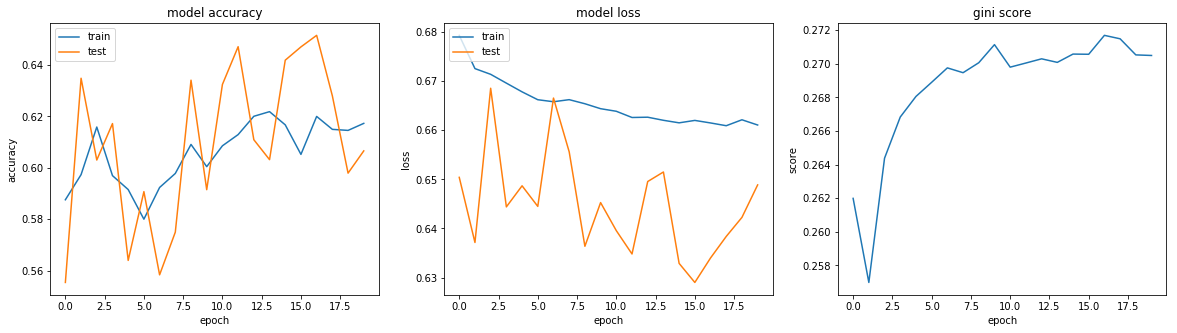

In [89]:
# summarize history for accuracy
# https://machinelearningmastery.com/display-deep-learning-model-training-history-in-keras/
plt.figure(figsize=(20,5))
plt.subplot(1,3,1)
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.subplot(1,3,2)
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.subplot(1,3,3)
# Summmary gini score
plt.plot(callback_gini_metric.history['gini'])
plt.title('gini score')
plt.ylabel('score')
plt.xlabel('epoch')
#plt.legend(['gini', loc='upper left')
plt.show()

### Load best model

In [90]:
if callback_gini_metric.save_best & callback_gini_metric.best_epoch>0:
    model.load_weights(model_path)

### Score model

In [91]:
score = model.evaluate(X_test, Y_test, verbose=1)
print("")
print("Test score:", score[0])
print('Test accuracy:', score[1])

87424/89282 [============================>.] - ETA: 0s
Test score: 0.634000390908
Test accuracy: 0.651564705092


In [92]:
y_pred = model.predict(X_test)

In [77]:
y_pred[:5]

array([[ 0.62719297,  0.372807  ],
       [ 0.57522607,  0.4247739 ],
       [ 0.46121645,  0.53878349],
       [ 0.554456  ,  0.44554394],
       [ 0.54295141,  0.45704854]], dtype=float32)

In [93]:
score = gini_normalized(Y_test[:,1], y_pred[:,1])
#score = gini_normalized(Y_test, y_pred)
print('Score:', score)

Score: 0.271686693875


# Predict and save submission

In [80]:
data = eval_set.drop('id', axis=1)
#data = eval_set[real_vars]
X_eval = scaler.transform(data)
Y_eval = model.predict(X_eval)

In [81]:
#(Y_eval<0).all() 
Y_eval[Y_eval<0]

array([], dtype=float32)

In [82]:
Y_eval = np.absolute(Y_eval)

In [84]:
eval_output = pd.DataFrame({'id': eval_data['id'], label: Y_eval[:,1]})
print(len(eval_output))
eval_output.head(10)

892816


,id,target
0,0,0.4583
1,1,0.4433
2,2,0.4422
3,3,0.3985
4,4,0.4542
5,5,0.5366
6,6,0.4242
7,8,0.4517
8,10,0.5962
9,11,0.5403


In [85]:
today = str(dtime.date.today())
print(today)
#eval_output.to_csv(DATA_DIR +'/' +today+'-submission.csv',index=False)
eval_output.to_csv(
            DATA_DIR + '/' + today + '-submission.csv.gz', index=False, float_format='%.5f',
            compression='gzip')

2017-10-16
